In [46]:
import pandas as pd 
import geopandas as gpd
import numpy as np 
import scipy.stats as stats
from scipy.stats import pearsonr
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import folium
from folium.plugins import MarkerCluster
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from adjustText import adjust_text

In [2]:
processed_data = pd.read_csv("../data/processed_data.csv")
processed_data.head(2)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC,Z_HDWY_DEV,Z_ADHERENCE,UNIQUE_TRIP_ID,PREVIOUS_ADHERENCE,NEXT_ADHERENCE
0,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.0,0,80,0.0,-0.032222,-0.139835,0.510757,120230801_345106,NaN,-1.916666
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.0,0,70,0.0,0.056190,0.202259,0.244098,120230801_345106,-0.183333,-1.716666


In [3]:
processed_data.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS', 'HDWY_DEV_PERC', 'Z_HDWY_DEV', 'Z_ADHERENCE',
       'UNIQUE_TRIP_ID', 'PREVIOUS_ADHERENCE', 'NEXT_ADHERENCE'],
      dtype='object')

How many routes on this data? 

In [4]:
routes = sorted(processed_data['ROUTE_ABBR'].unique())
print(routes)
print('Total:', len(routes))

[3, 7, 22, 23, 50, 52, 55, 56]
Total: 8


3 - West End 

7 - Hillsboro 

22 - Bordeaux

23 - Dickerson Pike

50 - Charlotte Pike

52 - Nolensville Pike

55 - Murfreesboro Pike

56 - Gallatin Pike

How many stops in each route? 

In [5]:
# Assuming your DataFrame is called processed_data
stops_per_route = processed_data.groupby('ROUTE_ABBR')['ROUTE_STOP_SEQUENCE'].agg(['unique', 'nunique']).reset_index()

# Rename the columns for clarity
stops_per_route.columns = ['ROUTE_ABBR', 'UNIQUE_STOPS', 'STOP_COUNT']

# Display the result
print(stops_per_route)

   ROUTE_ABBR                                       UNIQUE_STOPS  STOP_COUNT
0           3                [3.0, 4.0, 5.0, 6.0, 2.0, 7.0, 8.0]           7
1           7                                    [4.0, 5.0, 3.0]           3
2          22   [5.0, 10.0, 14.0, 1.0, 7.0, 8.0, 12.0, 9.0, 6.0]           9
3          23                     [5.0, 8.0, 3.0, 4.0, 2.0, 6.0]           6
4          50         [13.0, 14.0, 15.0, 16.0, 17.0, 12.0, 10.0]           7
5          52  [3.0, 4.0, 5.0, 9.0, 2.0, 10.0, 6.0, 7.0, 8.0,...          10
6          55              [6.0, 8.0, 9.0, 10.0, 11.0, 5.0, 7.0]           7
7          56             [8.0, 9.0, 10.0, 11.0, 6.0, 12.0, 7.0]           7


*Test code to see unique and nunique values in dataframe:*
    
stops_per_route = processed_data.groupby('ROUTE_ABBR')['TRIP_ID'].agg(['unique', 'nunique']).reset_index()

stops_per_route.columns = ['ROUTE_ABBR', 'UNIQUE_STOPS', 'STOP_COUNT']


**Question:** Which routes have the lowest headway deviation?

In [6]:
# Grouping by ROUTE and computing the mean, standard deviation, and count for HDWY_DEV and ADHERENCE
routes_stats = processed_data.groupby('ROUTE_ABBR').agg({
    'HDWY_DEV': [('mean_HDWY_DEV', 'mean'),
                 ('std_HDWY_DEV', 'std'),
                 ('count', 'count')],
    'ADHERENCE': [('mean_ADHERENCE', 'mean'),
                  ('std_ADHERENCE', 'std')]
}).reset_index()

# Rename columns 
routes_stats.columns = routes_stats.columns.droplevel(0)
routes_stats.rename(columns={'': 'ROUTE_ABBR'}, inplace=True)

routes_stats.head(10)

,ROUTE_ABBR,mean_HDWY_DEV,std_HDWY_DEV,count,mean_ADHERENCE,std_ADHERENCE
0,3,0.217566,4.937813,35053,-3.482933,3.814698
1,7,0.070005,4.754480,11181,-3.105211,3.743610
2,22,0.135953,3.852062,16286,-1.974458,2.817641
3,23,0.289960,4.259381,26899,-2.165748,2.678603
4,50,0.091506,4.294142,34183,-2.760195,3.134643
5,52,0.230035,5.315705,35623,-3.177448,4.031990
6,55,0.041813,5.479424,47402,-4.060704,4.437507
7,56,0.092424,4.416881,47672,-2.937731,3.393502


**Question:** Which stops in each routes have the lowest headway deviation?

In [7]:
# Grouping by ROUTE and STOPS and computing the mean, standard deviation, and count for HDWY_DEV and ADHERENCE
routes_stops_stats = processed_data.groupby(['ROUTE_ABBR', 'ROUTE_STOP_SEQUENCE']).agg({
    'HDWY_DEV': ['mean', 'std', 'count'],
    'ADHERENCE': ['mean', 'std']
}).reset_index()

# Rename the columns for clarity
routes_stops_stats.columns = ['ROUTE_ABBR', 'ROUTE_STOP_SEQUENCE', 'mean_HDWY_DEV', 'std_HDWY_DEV', 'count', 'mean_ADHERENCE', 'std_ADHERENCE']

# Remove NaN values 
routes_stops_stats = routes_stops_stats.dropna()

routes_stops_stats.head(20)

,ROUTE_ABBR,ROUTE_STOP_SEQUENCE,mean_HDWY_DEV,std_HDWY_DEV,count,mean_ADHERENCE,std_ADHERENCE
0,3,2.0,0.188099,4.211805,3903,-3.061602,2.769748
1,3,3.0,0.271677,5.165725,7840,-3.669619,3.959694
2,3,4.0,0.270955,5.140596,7847,-3.667798,3.996776
3,3,5.0,0.252256,5.186393,7846,-3.687847,4.165550
4,3,6.0,0.179086,4.524563,2064,-2.909560,3.016248
5,3,7.0,0.054672,5.101943,3685,-3.543265,4.176250
6,3,8.0,0.045922,3.235142,1868,-2.456995,2.137309
7,7,3.0,0.092325,4.399196,2823,-2.487655,3.094928
8,7,4.0,0.050331,5.286280,5577,-3.903688,4.289545
9,7,5.0,0.086803,3.900128,2781,-2.130834,2.667453


**Order the routes and stops by highest mean_HDWY_DEV**

In [58]:
# Sort the DataFrame by absolute values of mean_HDWY_DEV
sorted_routes_stops_stats = routes_stops_stats.iloc[(-routes_stops_stats['mean_HDWY_DEV'].abs()).argsort()]

# Display the sorted DataFrame
sorted_routes_stops_stats.head(10)

,ROUTE_ABBR,ROUTE_STOP_SEQUENCE,mean_HDWY_DEV,std_HDWY_DEV,count,mean_ADHERENCE,std_ADHERENCE
41,52,11.0,1.755642,9.802164,960,-6.442899,6.378233
50,56,7.0,1.649123,4.622264,19,-2.147368,4.833200
44,55,7.0,1.450000,3.262418,16,-3.202083,2.175775
38,52,8.0,1.414706,6.228864,153,-0.078105,3.815069
23,23,6.0,-1.075947,5.796632,2112,-2.421725,2.857800
24,23,8.0,0.602448,5.275986,2274,-4.288427,3.372528
20,23,3.0,0.415165,4.076052,7361,-1.704714,2.588212
21,23,4.0,0.402015,4.040691,7477,-1.867110,2.526298
19,23,2.0,0.358735,3.831620,3686,-2.485277,2.443250
25,50,10.0,0.350709,3.847163,47,-1.062411,2.353003


In [8]:
coordinates_per_route_stop = processed_data.groupby(['ROUTE_ABBR', 'ROUTE_STOP_SEQUENCE'])[['LATITUDE', 'LONGITUDE']].mean().reset_index()
coordinates_per_route_stop = coordinates_per_route_stop.dropna()
coordinates_per_route_stop.head(10)

,ROUTE_ABBR,ROUTE_STOP_SEQUENCE,LATITUDE,LONGITUDE
0,3,2.0,36.167091,-86.781923
1,3,3.0,36.148843,-86.804531
2,3,4.0,36.143138,-86.814873
3,3,5.0,36.126214,-86.845855
4,3,6.0,36.149179,-86.858044
5,3,7.0,36.069408,-86.933516
6,3,8.0,36.079608,-86.955657
7,7,3.0,36.167091,-86.781923
8,7,4.0,36.138627,-86.800622
9,7,5.0,36.107575,-86.812719


In [9]:
# Merge the two dataframes on 'ROUTE_ABBR' and 'ROUTE_STOP_SEQUENCE'
combined_df = pd.merge(routes_stops_stats, coordinates_per_route_stop, on=['ROUTE_ABBR', 'ROUTE_STOP_SEQUENCE'])

# Display the combined dataframe
print(combined_df)

    ROUTE_ABBR  ROUTE_STOP_SEQUENCE  mean_HDWY_DEV  std_HDWY_DEV  count  \
0            3                  2.0       0.188099      4.211805   3903   
1            3                  3.0       0.271677      5.165725   7840   
2            3                  4.0       0.270955      5.140596   7847   
3            3                  5.0       0.252256      5.186393   7846   
4            3                  6.0       0.179086      4.524563   2064   
5            3                  7.0       0.054672      5.101943   3685   
6            3                  8.0       0.045922      3.235142   1868   
7            7                  3.0       0.092325      4.399196   2823   
8            7                  4.0       0.050331      5.286280   5577   
9            7                  5.0       0.086803      3.900128   2781   
10          22                  1.0       0.135281      3.681962   3533   
11          22                  5.0       0.232537      4.141287   7037   
12          22           

**Data Visualization** 

I want to see the location of each stop on a specific route. 

Add the following data: 
- zipcode dataset (geojson file) from https://data.nashville.gov/Metro-Government/Zip-Codes/72um-tmbe. 
- bus stops data (csv) from https://data.nashville.gov/Transportation/WeGo-Transit-Bus-Stops/vfe9-k7vc. 

In [10]:
zipcodes = gpd.read_file('../data/zipcodes.geojson')

bus_stops = pd.read_csv('../data/WeGo_Transit_Bus_Stops_20231025.csv')

In [11]:
zipcodes.head(3)

,zipcode,poname,created_date,objectid,globalid,created_user,last_edited_date,last_edited_user,geometry
0,37218,NASHVILLE,None,55,{3CB897BE-ACCB-46CB-BA4E-6F5E39D6C451},None,None,None,"MULTIPOLYGON (((-86.88231 36.26248, -86.88270 ..."
1,37080,JOELTON,None,32,{C63ADE44-CC5E-4CCD-BBF0-4B8A64864B42},None,None,None,"MULTIPOLYGON (((-86.90742 36.39053, -86.90725 ..."
2,37027,BRENTWOOD,None,44,{8846D4AC-5F8A-4434-8348-C9A28297FA4E},None,None,None,"MULTIPOLYGON (((-86.67793 35.98782, -86.67941 ..."


**To convert a DataFrame to a GeoDataFrame** 

We need geometry and crs (coordinate reference system) 
- Add geometry from lat and long columns. 
- Use crs from zipcodes data. 
- Convert to GeoDataFrame, which has three parameters: a DataFrame, CRS, and geometry. 

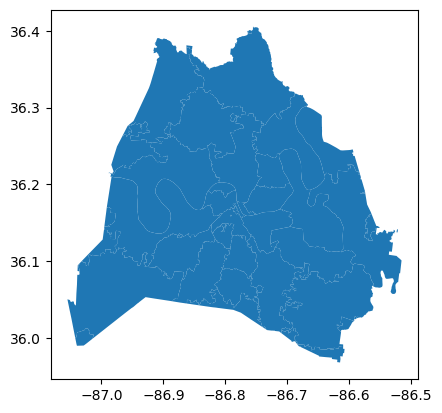

In [12]:
zipcodes.plot();

In [13]:
processed_data['GEOMETRY'] = gpd.points_from_xy(processed_data['LONGITUDE'], processed_data['LATITUDE'])
bus_routes_geo = gpd.GeoDataFrame(processed_data, 
                             crs = zipcodes.crs, 
                             geometry = processed_data['GEOMETRY'])
bus_routes_geo.head(5)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC,Z_HDWY_DEV,Z_ADHERENCE,UNIQUE_TRIP_ID,PREVIOUS_ADHERENCE,NEXT_ADHERENCE,GEOMETRY,geometry
0,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,80,0.000000,-0.032222,-0.139835,0.510757,120230801_345106,NaN,-1.916666,POINT (-86.81445 36.18218),POINT (-86.81445 36.18218)
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,70,0.000000,0.056190,0.202259,0.244098,120230801_345106,-0.183333,-1.716666,POINT (-86.83998 36.19345),POINT (-86.83998 36.19345)
2,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,63,13.216666,0.076190,0.300000,0.274867,120230801_345106,-1.916666,NaN,POINT (-86.84771 36.18125),POINT (-86.84771 36.18125)
3,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,97,10.800000,-0.144444,-0.374878,0.336403,120230801_345107,NaN,1.500000,POINT (-86.78192 36.16709),POINT (-86.78192 36.16709)
4,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,112,0.000000,-0.258889,-0.614577,0.769723,120230801_345107,-1.316666,NaN,POINT (-86.81422 36.18348),POINT (-86.81422 36.18348)


In [14]:
bus_routes_geo.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS', 'HDWY_DEV_PERC', 'Z_HDWY_DEV', 'Z_ADHERENCE',
       'UNIQUE_TRIP_ID', 'PREVIOUS_ADHERENCE', 'NEXT_ADHERENCE', 'GEOMETRY',
       'geometry'],
      dtype='object')

In [15]:
columns_to_drop = ['HDWY_DEV_PERC', 'Z_HDWY_DEV', 'Z_ADHERENCE',
       'UNIQUE_TRIP_ID', 'PREVIOUS_ADHERENCE', 'NEXT_ADHERENCE', 'GEOMETRY']
bus_routes_geo = bus_routes_geo.drop(columns = columns_to_drop)

In [16]:
bus_routes_geo.head(5)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,geometry
0,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,-0.483334,0,0,1,0,0.0,0,80,0.000000,POINT (-86.81445 36.18218)
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,1.966666,0,0,1,0,0.0,0,70,0.000000,POINT (-86.83998 36.19345)
2,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,2.666666,0,0,1,0,0.0,0,63,13.216666,POINT (-86.84771 36.18125)
3,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-2.166667,0,0,1,0,0.0,0,97,10.800000,POINT (-86.78192 36.16709)
4,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-3.883334,1,0,0,0,0.0,0,112,0.000000,POINT (-86.81422 36.18348)


In [17]:
type(bus_routes_geo)

geopandas.geodataframe.GeoDataFrame

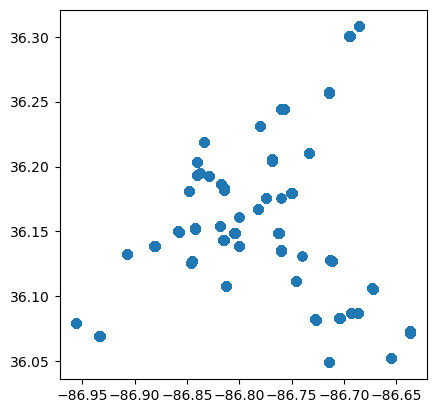

In [18]:
bus_routes_geo.plot();

In [19]:
bus_routes_geo.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS', 'geometry'],
      dtype='object')

In [20]:
# Dictionary for bus routes
bus_routes = {
    3: 'West End', 
    7: 'Hillsboro', 
    22: 'Bordeaux', 
    23: 'Dickerson Pike', 
    50: 'Charlotte Pike', 
    52: 'Nolensville Pike', 
    55: 'Murfreesboro Pike', 
    56: 'Gallatin Pike'
}

# Create a new column ROUTE_NAME by mapping ROUTE_ABBR to the corresponding route name
bus_routes_geo['ROUTE_NAME'] = bus_routes_geo['ROUTE_ABBR'].map(bus_routes)

# Combine ROUTE_ABBR and ROUTE_NAME in a new column
bus_routes_geo['ROUTE_ABBR'] = bus_routes_geo['ROUTE_ABBR'].astype(str)
bus_routes_geo['ROUTE_NAME'] = bus_routes_geo['ROUTE_ABBR'] + '-' + bus_routes_geo['ROUTE_NAME']


In [21]:
bus_routes_geo.head(5)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,geometry,ROUTE_NAME
0,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0,0,1,0,0.0,0,80,0.000000,POINT (-86.81445 36.18218),22-Bordeaux
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0,0,1,0,0.0,0,70,0.000000,POINT (-86.83998 36.19345),22-Bordeaux
2,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0,0,1,0,0.0,0,63,13.216666,POINT (-86.84771 36.18125),22-Bordeaux
3,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,0,0,1,0,0.0,0,97,10.800000,POINT (-86.78192 36.16709),22-Bordeaux
4,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,1,0,0,0,0.0,0,112,0.000000,POINT (-86.81422 36.18348),22-Bordeaux


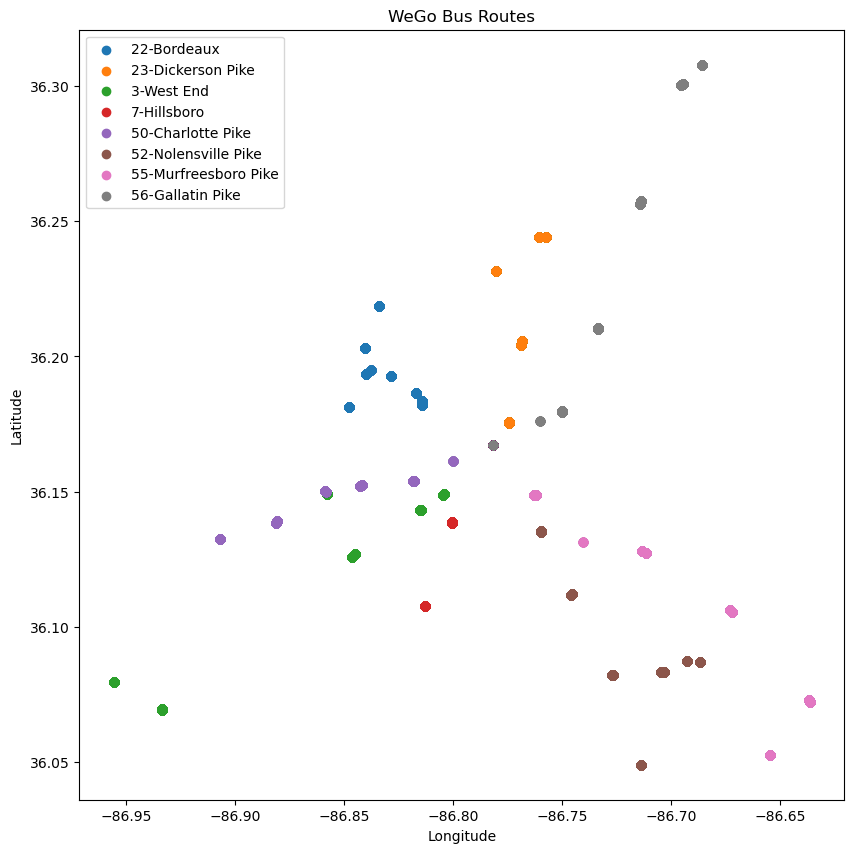

In [22]:
bus_routes_geo.plot(figsize=(10, 10), color='lightgray')

# Iterate through unique route names
for route_name in bus_routes_geo['ROUTE_NAME'].unique():
    # Filter data for the current route
    route_data = bus_routes_geo[bus_routes_geo['ROUTE_NAME'] == route_name]
    
    # Plot the route with label
    route_data.plot(ax=plt.gca(), label=route_name)

# Set plot labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('WeGo Bus Routes')
plt.legend()

# Show the plot
plt.show()

**Data Visualization:** Check what CRS our data is at.

In [23]:
bus_routes_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

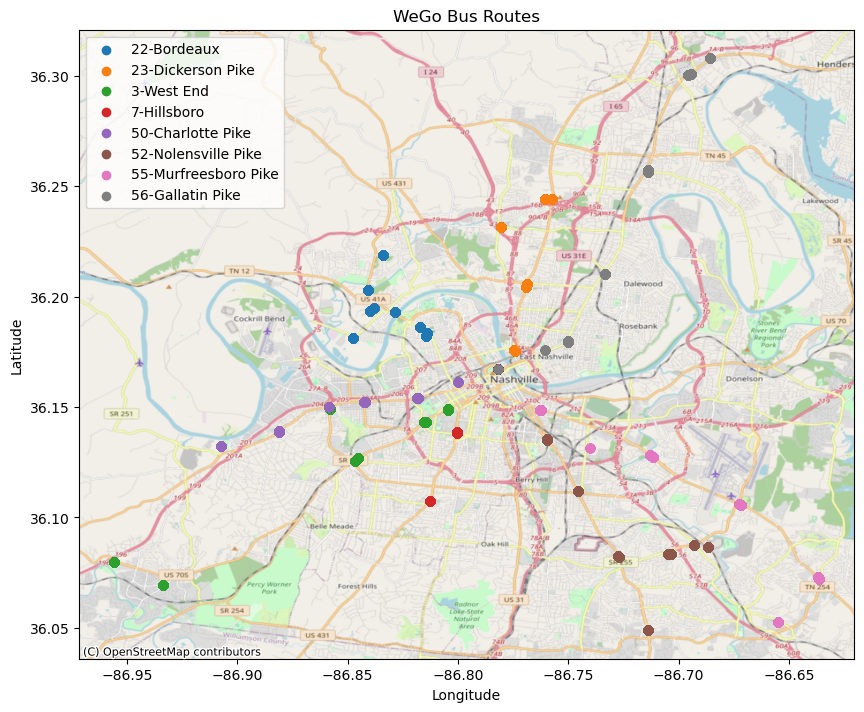

In [56]:
# Set the CRS for the GeoDataFrame
bus_routes_geo.crs = 'EPSG:4326'

# Plot bus routes
ax = bus_routes_geo.plot(figsize=(10, 10), color='lightgray')

# Iterate through unique route names
for route_name in bus_routes_geo['ROUTE_NAME'].unique():
    # Filter data for the current route
    route_data = bus_routes_geo[bus_routes_geo['ROUTE_NAME'] == route_name]
    
    # Plot the route with label
    route_data.plot(ax=ax, label=route_name)

# Set plot labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('WeGo Bus Routes')
plt.legend()

# Add Google Map as the basemap
ctx.add_basemap(ax, crs=bus_routes_geo.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Save the map 
plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/busroutes.png')

# Show the plot
plt.show()

**Visualization:** Which stops in each route tend to be late or early or on time? 

In [26]:
combined_df['GEOMETRY'] = gpd.points_from_xy(combined_df['LONGITUDE'], combined_df['LATITUDE'])
combined_df_geo = gpd.GeoDataFrame(combined_df,
                             geometry = combined_df['GEOMETRY'])
combined_df_geo.head(3)

,ROUTE_ABBR,ROUTE_STOP_SEQUENCE,mean_HDWY_DEV,std_HDWY_DEV,count,mean_ADHERENCE,std_ADHERENCE,LATITUDE,LONGITUDE,GEOMETRY,geometry
0,3,2.0,0.188099,4.211805,3903,-3.061602,2.769748,36.167091,-86.781923,POINT (-86.78192 36.16709),POINT (-86.78192 36.16709)
1,3,3.0,0.271677,5.165725,7840,-3.669619,3.959694,36.148843,-86.804531,POINT (-86.80453 36.14884),POINT (-86.80453 36.14884)
2,3,4.0,0.270955,5.140596,7847,-3.667798,3.996776,36.143138,-86.814873,POINT (-86.81487 36.14314),POINT (-86.81487 36.14314)


In [28]:
# Dictionary for bus routes
bus_routes = {
    3: 'West End', 
    7: 'Hillsboro', 
    22: 'Bordeaux', 
    23: 'Dickerson Pike', 
    50: 'Charlotte Pike', 
    52: 'Nolensville Pike', 
    55: 'Murfreesboro Pike', 
    56: 'Gallatin Pike'
}

# Create a new column ROUTE_NAME by mapping ROUTE_ABBR to the corresponding route name
combined_df_geo['ROUTE_NAME'] = combined_df_geo['ROUTE_ABBR'].map(bus_routes)

# Combine ROUTE_ABBR and ROUTE_NAME in a new column
combined_df_geo['ROUTE_ABBR'] = combined_df_geo['ROUTE_ABBR'].astype(str)
combined_df_geo['ROUTE_NAME'] = combined_df_geo['ROUTE_ABBR'] + '-' + combined_df_geo['ROUTE_NAME']
combined_df_geo.head(5)

,ROUTE_ABBR,ROUTE_STOP_SEQUENCE,mean_HDWY_DEV,std_HDWY_DEV,count,mean_ADHERENCE,std_ADHERENCE,LATITUDE,LONGITUDE,GEOMETRY,geometry,ROUTE_NAME
0,3,2.0,0.188099,4.211805,3903,-3.061602,2.769748,36.167091,-86.781923,POINT (-86.78192 36.16709),POINT (-86.78192 36.16709),3-West End
1,3,3.0,0.271677,5.165725,7840,-3.669619,3.959694,36.148843,-86.804531,POINT (-86.80453 36.14884),POINT (-86.80453 36.14884),3-West End
2,3,4.0,0.270955,5.140596,7847,-3.667798,3.996776,36.143138,-86.814873,POINT (-86.81487 36.14314),POINT (-86.81487 36.14314),3-West End
3,3,5.0,0.252256,5.186393,7846,-3.687847,4.165550,36.126214,-86.845855,POINT (-86.84586 36.12621),POINT (-86.84586 36.12621),3-West End
4,3,6.0,0.179086,4.524563,2064,-2.909560,3.016248,36.149179,-86.858044,POINT (-86.85804 36.14918),POINT (-86.85804 36.14918),3-West End


In [75]:
# Create new column that combines route and stop sequence 
combined_df_geo['ROUTE_STOP'] = 'R ' + combined_df_geo['ROUTE_ABBR'].astype(str) + ' - S ' + combined_df_geo['ROUTE_STOP_SEQUENCE'].astype(str)
combined_df_geo.head(5)

,ROUTE_ABBR,ROUTE_STOP_SEQUENCE,mean_HDWY_DEV,std_HDWY_DEV,count,mean_ADHERENCE,std_ADHERENCE,LATITUDE,LONGITUDE,GEOMETRY,geometry,ROUTE_NAME,ROUTE_STOP
0,3,2.0,0.188099,4.211805,3903,-3.061602,2.769748,36.167091,-86.781923,POINT (-86.78192 36.16709),POINT (-86.78192 36.16709),3-West End,R 3 - S 2.0
1,3,3.0,0.271677,5.165725,7840,-3.669619,3.959694,36.148843,-86.804531,POINT (-86.80453 36.14884),POINT (-86.80453 36.14884),3-West End,R 3 - S 3.0
2,3,4.0,0.270955,5.140596,7847,-3.667798,3.996776,36.143138,-86.814873,POINT (-86.81487 36.14314),POINT (-86.81487 36.14314),3-West End,R 3 - S 4.0
3,3,5.0,0.252256,5.186393,7846,-3.687847,4.165550,36.126214,-86.845855,POINT (-86.84586 36.12621),POINT (-86.84586 36.12621),3-West End,R 3 - S 5.0
4,3,6.0,0.179086,4.524563,2064,-2.909560,3.016248,36.149179,-86.858044,POINT (-86.85804 36.14918),POINT (-86.85804 36.14918),3-West End,R 3 - S 6.0


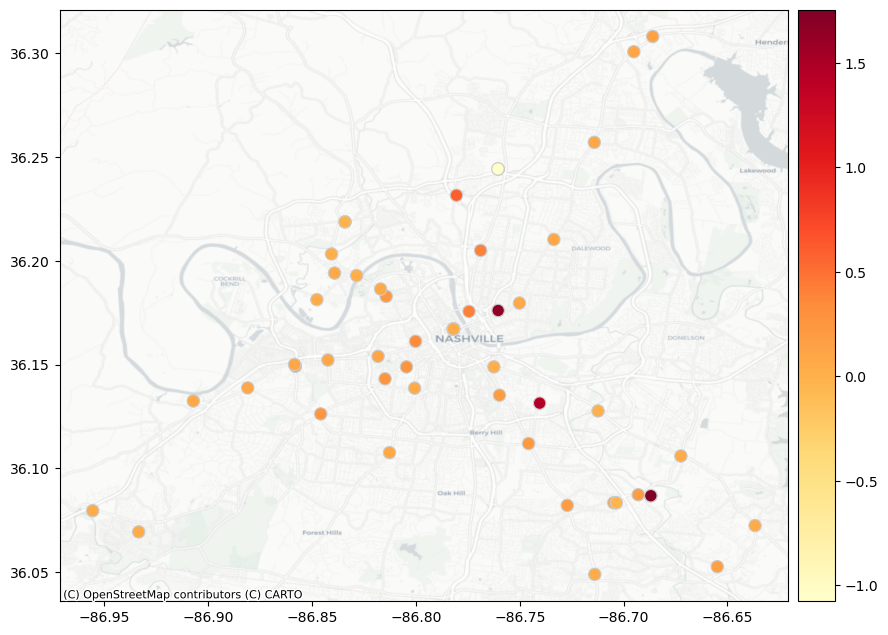

In [77]:
gdf = gpd.GeoDataFrame(combined_df_geo, geometry='geometry')

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # Adjust the '5%' to control the width of the colorbar

gdf.plot(column='mean_HDWY_DEV', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax, markersize=80)

# Add labels and title
# plt.title('Heatmap of mean_HDWY_DEV')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# Add Google Map as the basemap
ctx.add_basemap(ax, crs=combined_df_geo.crs, source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

C:\Users\MJ\AppData\Local\Temp\ipykernel_19140\874268493.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  annotations = gpd.GeoDataFrame(geometry=gdf.centroid, data={'ROUTE_STOP': gdf['ROUTE_STOP']})


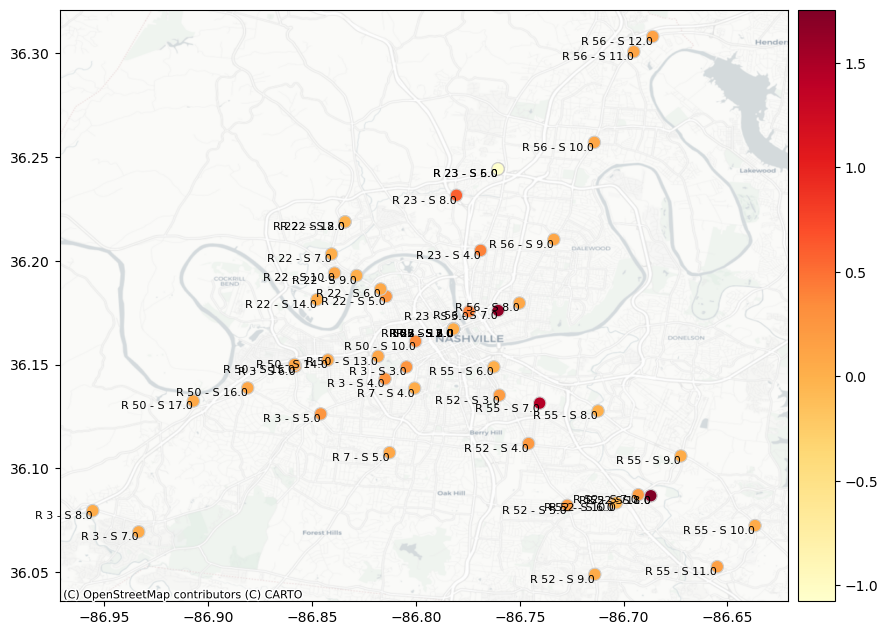

In [79]:
# Create a GeoDataFrame with route names as annotations
annotations = gpd.GeoDataFrame(geometry=gdf.centroid, data={'ROUTE_STOP': gdf['ROUTE_STOP']})

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # Adjust the '5%' to control the width of the colorbar

# Customize the dot size using the s parameter
gdf.plot(column='mean_HDWY_DEV', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax, markersize=80)

# Annotate each point with the route name
texts = [ax.text(x, y, label, fontsize=8, ha='right', va='top') for x, y, label in zip(annotations.geometry.x, annotations.geometry.y, annotations['ROUTE_STOP'])]
# Add Google Map as the basemap
ctx.add_basemap(ax, crs=combined_df_geo.crs, source=ctx.providers.CartoDB.Positron)

# Save the plot as an image 
plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/heatmap_map1.png', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

C:\Users\MJ\AppData\Local\Temp\ipykernel_19140\3506400155.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  annotations = gpd.GeoDataFrame(geometry=gdf.centroid, data={'ROUTE_STOP': gdf['ROUTE_STOP']})


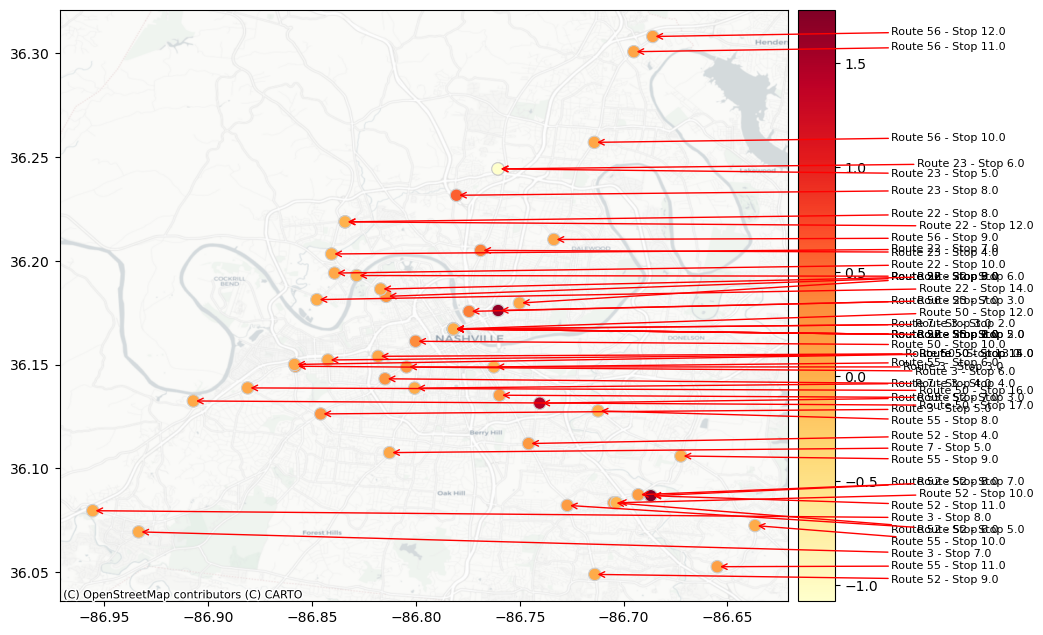

In [66]:
# Create a GeoDataFrame with route names as annotations
annotations = gpd.GeoDataFrame(geometry=gdf.centroid, data={'ROUTE_STOP': gdf['ROUTE_STOP']})

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # Adjust the '5%' to control the width of the colorbar

# Customize the dot size using the s parameter
gdf.plot(column='mean_HDWY_DEV', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax, markersize=80)

# Annotate each point with the route name
texts = [ax.text(x, y, label, fontsize=8, ha='left', va='bottom') for x, y, label in zip(annotations.geometry.x, annotations.geometry.y, annotations['ROUTE_STOP'])]

# Use adjust_text to avoid label overlap with arrows
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'), autoalign='xy', force_text=0.1, force_points=0.1)

# Add Google Map as the basemap
ctx.add_basemap(ax, crs=combined_df_geo.crs, source=ctx.providers.CartoDB.Positron)

# Save the plot as an image 
plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/heatmap_map2.png', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

**Question:** How does *routes* impact headway deviation? 

In [ ]:
# Check correlation to see how adherence at the first trip's first stop influences the adherence at the next stop
correlation = processed_data['ROUTE_ABBR'].corr(processed_data['HDWY_DEV'])
print("Correlation between route and headway deviation:", correlation)

In [ ]:
processed_data['ROUTE_ABBR'] = processed_data['ROUTE_ABBR'].astype('category')  

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(processed_data['ROUTE_ABBR'], processed_data['HDWY_DEV'])
plt.xlabel("ROUTE")
plt.ylabel("HDWY_DEV")
plt.show()

In [ ]:
lm = smf.ols('HDWY_DEV ~ ROUTE_ABBR', data = processed_data).fit()
lm.summary()

In [ ]:
lm = smf.ols('HDWY_DEV ~ C(OPERATOR) + C(ROUTE_ABBR)', data = processed_data).fit()
lm.summary()

**Goal:** Use routes_stats dataframe and map to visualize data 